# Field inference from multiple uniformly magnetized prisms

This notebook demonstrates that it is possible to learn analytical forms like the demagnetizing field of a uniformly magnetized prism with good accuracy with a physically credible network and desirable scaling behaviour. In this demonstration, we want to model the potential/field from multiple fixed sources at arbitrary field points, and to do so while running over the sources and inference points separately; i.e. O(M + N) and not O(M * N).

We suppose this to be possible because of the principle of superposition for potentials / fields, and our implementation separately the input of magnetic sources (the 'priming' network) from the inference ('main' network). In particular, we try learning a hypernetwork where the role of the priming network is to output the weights for the main network. We will use jax, equinox and optax to develop a model combining neural and analytical (autodiff) components.

In [1]:
import optax
from hypermagnetics import plots
from hypermagnetics.sources import configure
from hypermagnetics.models.hyper_mlp import HyperMLP
from hypermagnetics.measures import loss, accuracy
from hypermagnetics.runner import fit
import matplotlib.pyplot as plt
import scienceplots  # noqa

plt.style.use(["science", "ieee"])

## I. Target definition and data generation

We expect the neural components of the model to learn transcendental functions. The demagnetising field field at $\mathbf{r}$ from a collection of uniformly magnetized prisms with moments $\mathbf{m}_i$ and positions $\mathbf{r}_i$ is computed via the scalar potential as:

$$
\begin{align}
    \begin{bmatrix} F(x,y,z) \\ F(y,z,x) \\F(z,x,y) \\ \end{bmatrix}
    &= 
    \begin{bmatrix}
    \arctan\left(\frac{yz}{xr}\right) & -\log(z+r) & -\log(y+r) \\
    -\log(z+r) & \arctan\left(\frac{zx}{yr}\right) & -\log(x+r) \\
    -\log(y+r) & -\log(x+r) & \arctan\left(\frac{xy}{zr}\right) \\
    \end{bmatrix}
    \begin{bmatrix} x \\ y \\ z \end{bmatrix}& \\
    &\equiv \mathbb{F}\cdot{\mathbf{r}}&&
\end{align}
$$.

In two dimensions (infintely thin uniformly magnetised plate), this simplifies to:
$$
\begin{align}
    \begin{bmatrix} F(x,y) \\ F(y,x) \\ \end{bmatrix}
    &=
    \begin{bmatrix}
    -\log(y+r) \cdot x \\
    -\log(x+r) \cdot y \\
    \end{bmatrix}&&
\end{align}
$$.

$$
\phi = - \frac{1}{2 \pi} \mathbf{m}\cdot\left.\left(\mathbb{F}\cdot\mathbf{r}\right)\right|^{\{+a,+b\}}_{\{-a,-b\}},
$$


We generate random samples to serve as the training data, precomputing the target potential values. Using a fixed training set helps with the stability of training, but we refresh the validation set each time its accuracy computation is needed. First, we describe the collection of sources.

2024-06-18 21:16:56.539925: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


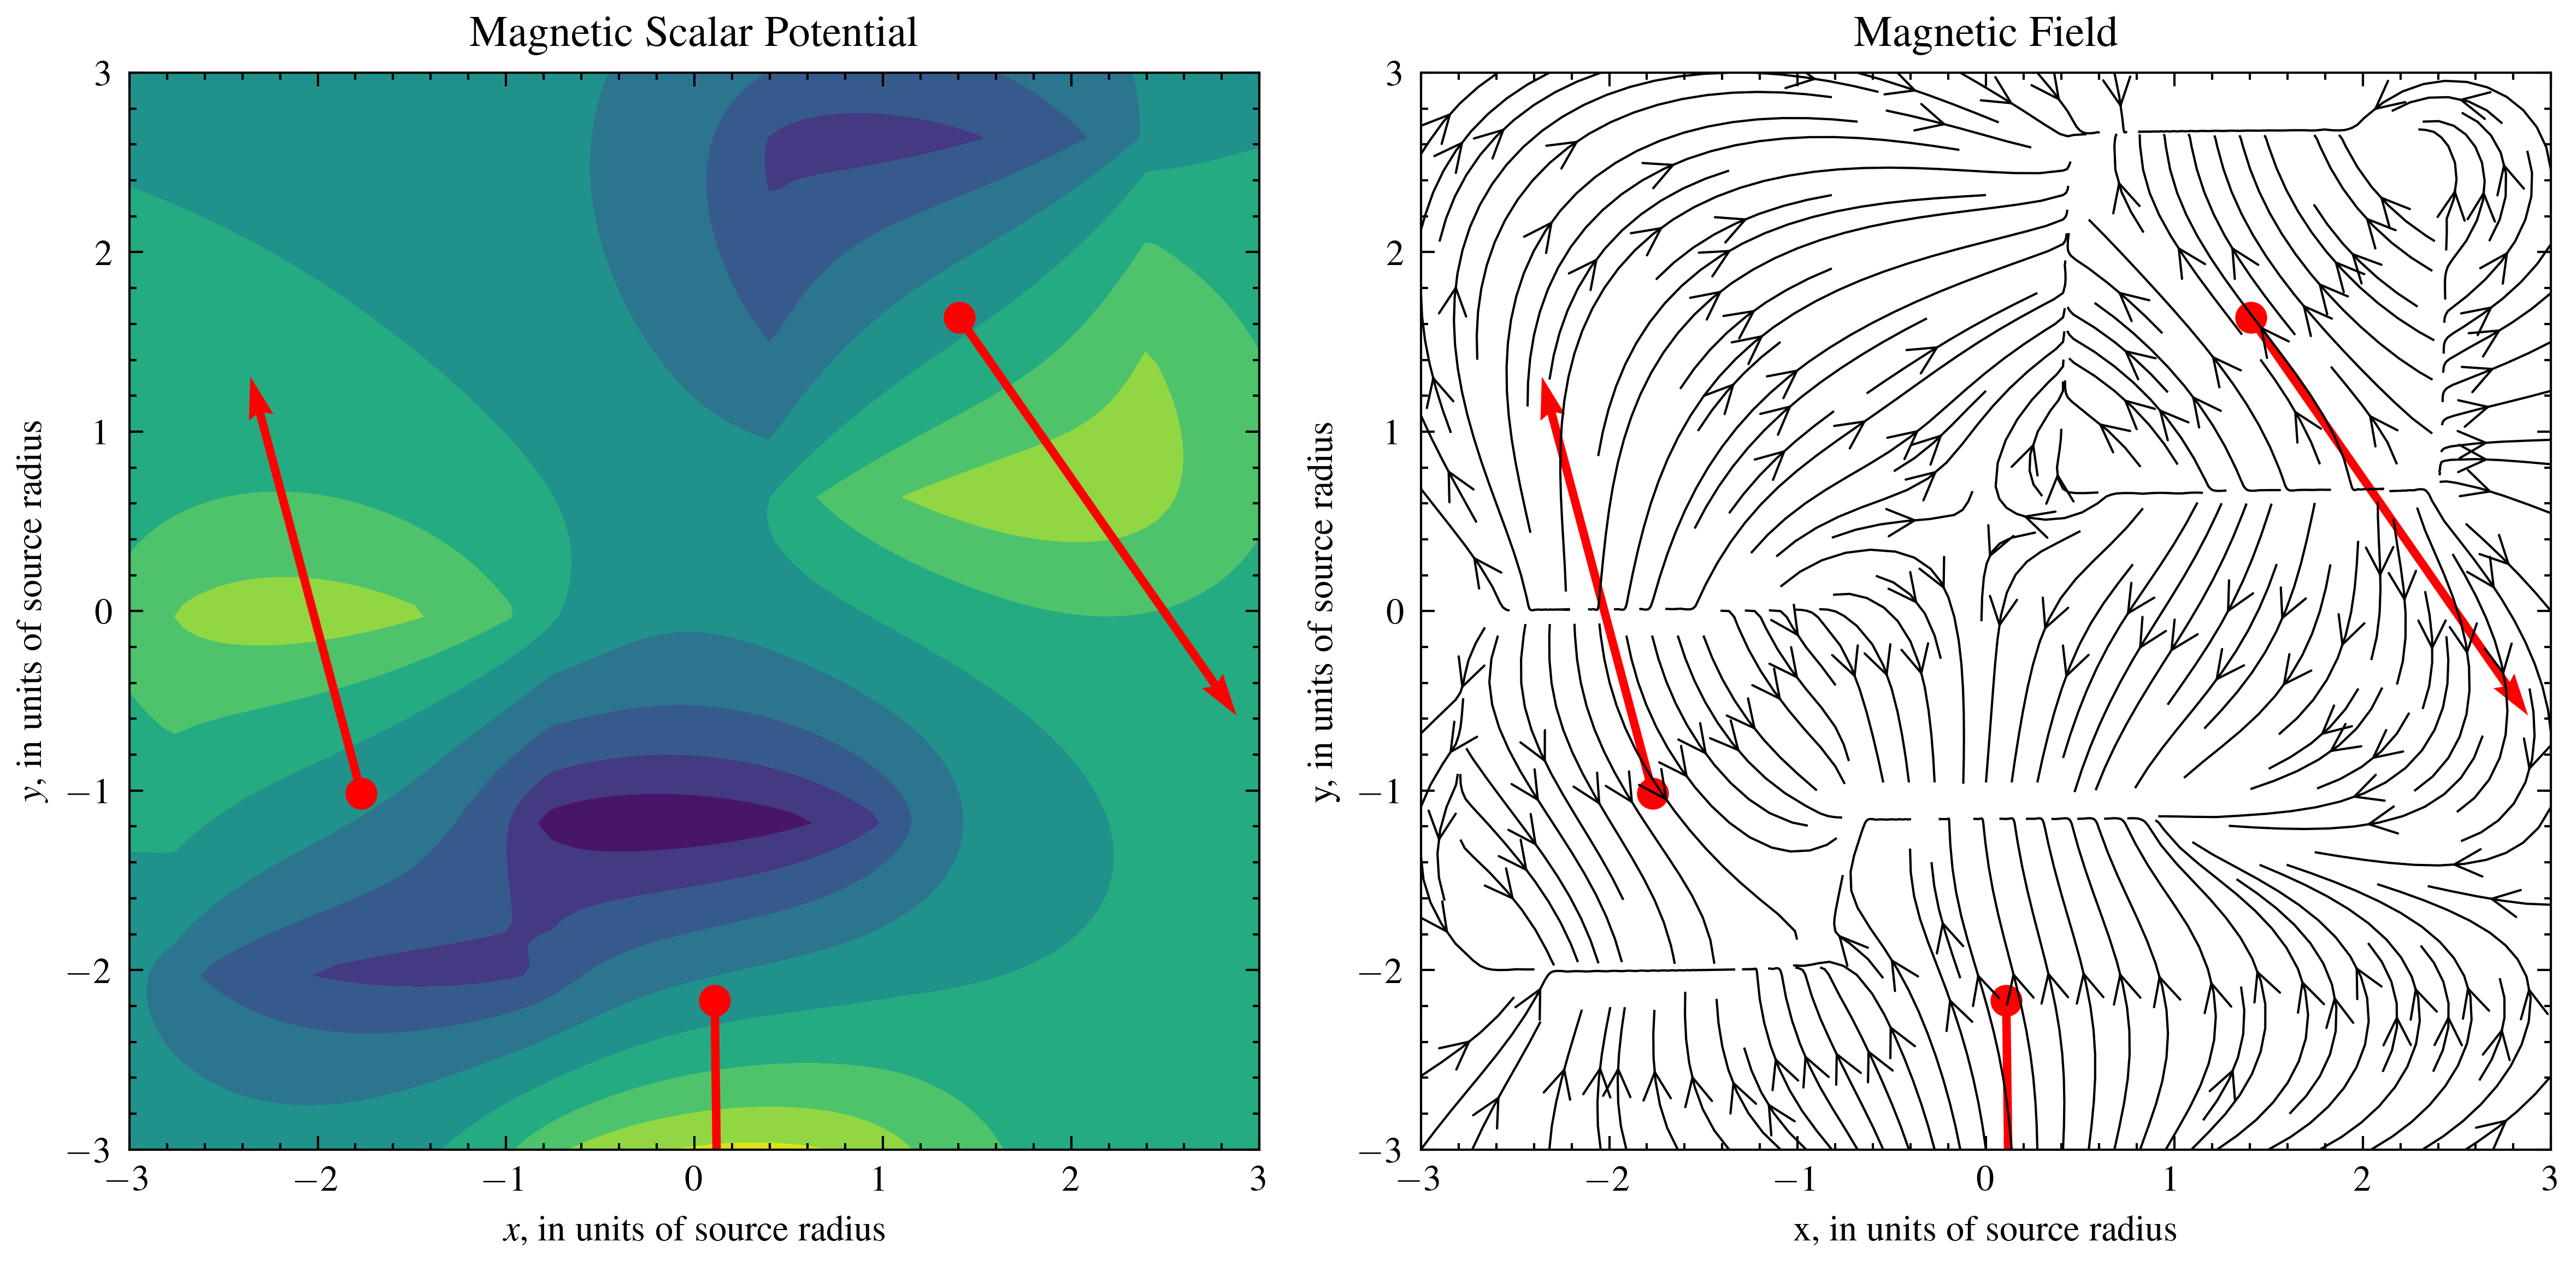

In [2]:
source_config = {
    "shape": "prism",
    "n_samples": 1,
    "lim": 3,
    "res": 100,
    "dim": 3,
}
train = configure(**source_config, n_sources=3, seed=110)
val = configure(**source_config, n_sources=1, seed=101)
plots(train, idx=0)

In [3]:
model = HyperMLP(20, 3, 2, 3, seed=42)
print(loss(model, train), accuracy(model, train))

3.2656076 100.286255


In [6]:
schedule = [
    # {"optim": optax.adam, "epochs": 5000, "params": {"learning_rate": 1e-2}},
    # {"optim": optax.adam, "epochs": 5000, "params": {"learning_rate": 1e-3}},
    # {"optim": optax.adam, "epochs": 5000, "params": {"learning_rate": 1e-4}},
    {"optim": optax.adam, "epochs": 25000, "params": {"learning_rate": 1e-5}},
]

for trainer_config in schedule:
    optim = trainer_config["optim"](**trainer_config["params"])
    model = fit(trainer_config, optim, model, train, val, every=1000)

{'epoch': 0, 'train_loss': 0.02578939124941826, 'train_err': 59.606849670410156, 'field_err': 34.163246154785156, 'cos_sim': 0.16120587289333344, 'test_err': 144.86404418945312}
{'epoch': 1000, 'train_loss': 0.022854331880807877, 'train_err': 1.6024686098098755, 'field_err': 5.718049049377441, 'cos_sim': 0.011666935868561268, 'test_err': 140.64503479003906}
{'epoch': 2000, 'train_loss': 0.020609406754374504, 'train_err': 1.3852852582931519, 'field_err': 5.2230305671691895, 'cos_sim': 0.010763543657958508, 'test_err': 139.7517852783203}
{'epoch': 3000, 'train_loss': 0.021515745669603348, 'train_err': 2.1852293014526367, 'field_err': 4.825740814208984, 'cos_sim': 0.010296461172401905, 'test_err': 138.48532104492188}
{'epoch': 4000, 'train_loss': 0.021041186526417732, 'train_err': 2.7947003841400146, 'field_err': 5.006525993347168, 'cos_sim': 0.009737852960824966, 'test_err': 136.93954467773438}
{'epoch': 5000, 'train_loss': 0.025719955563545227, 'train_err': 3.37100887298584, 'field_err'

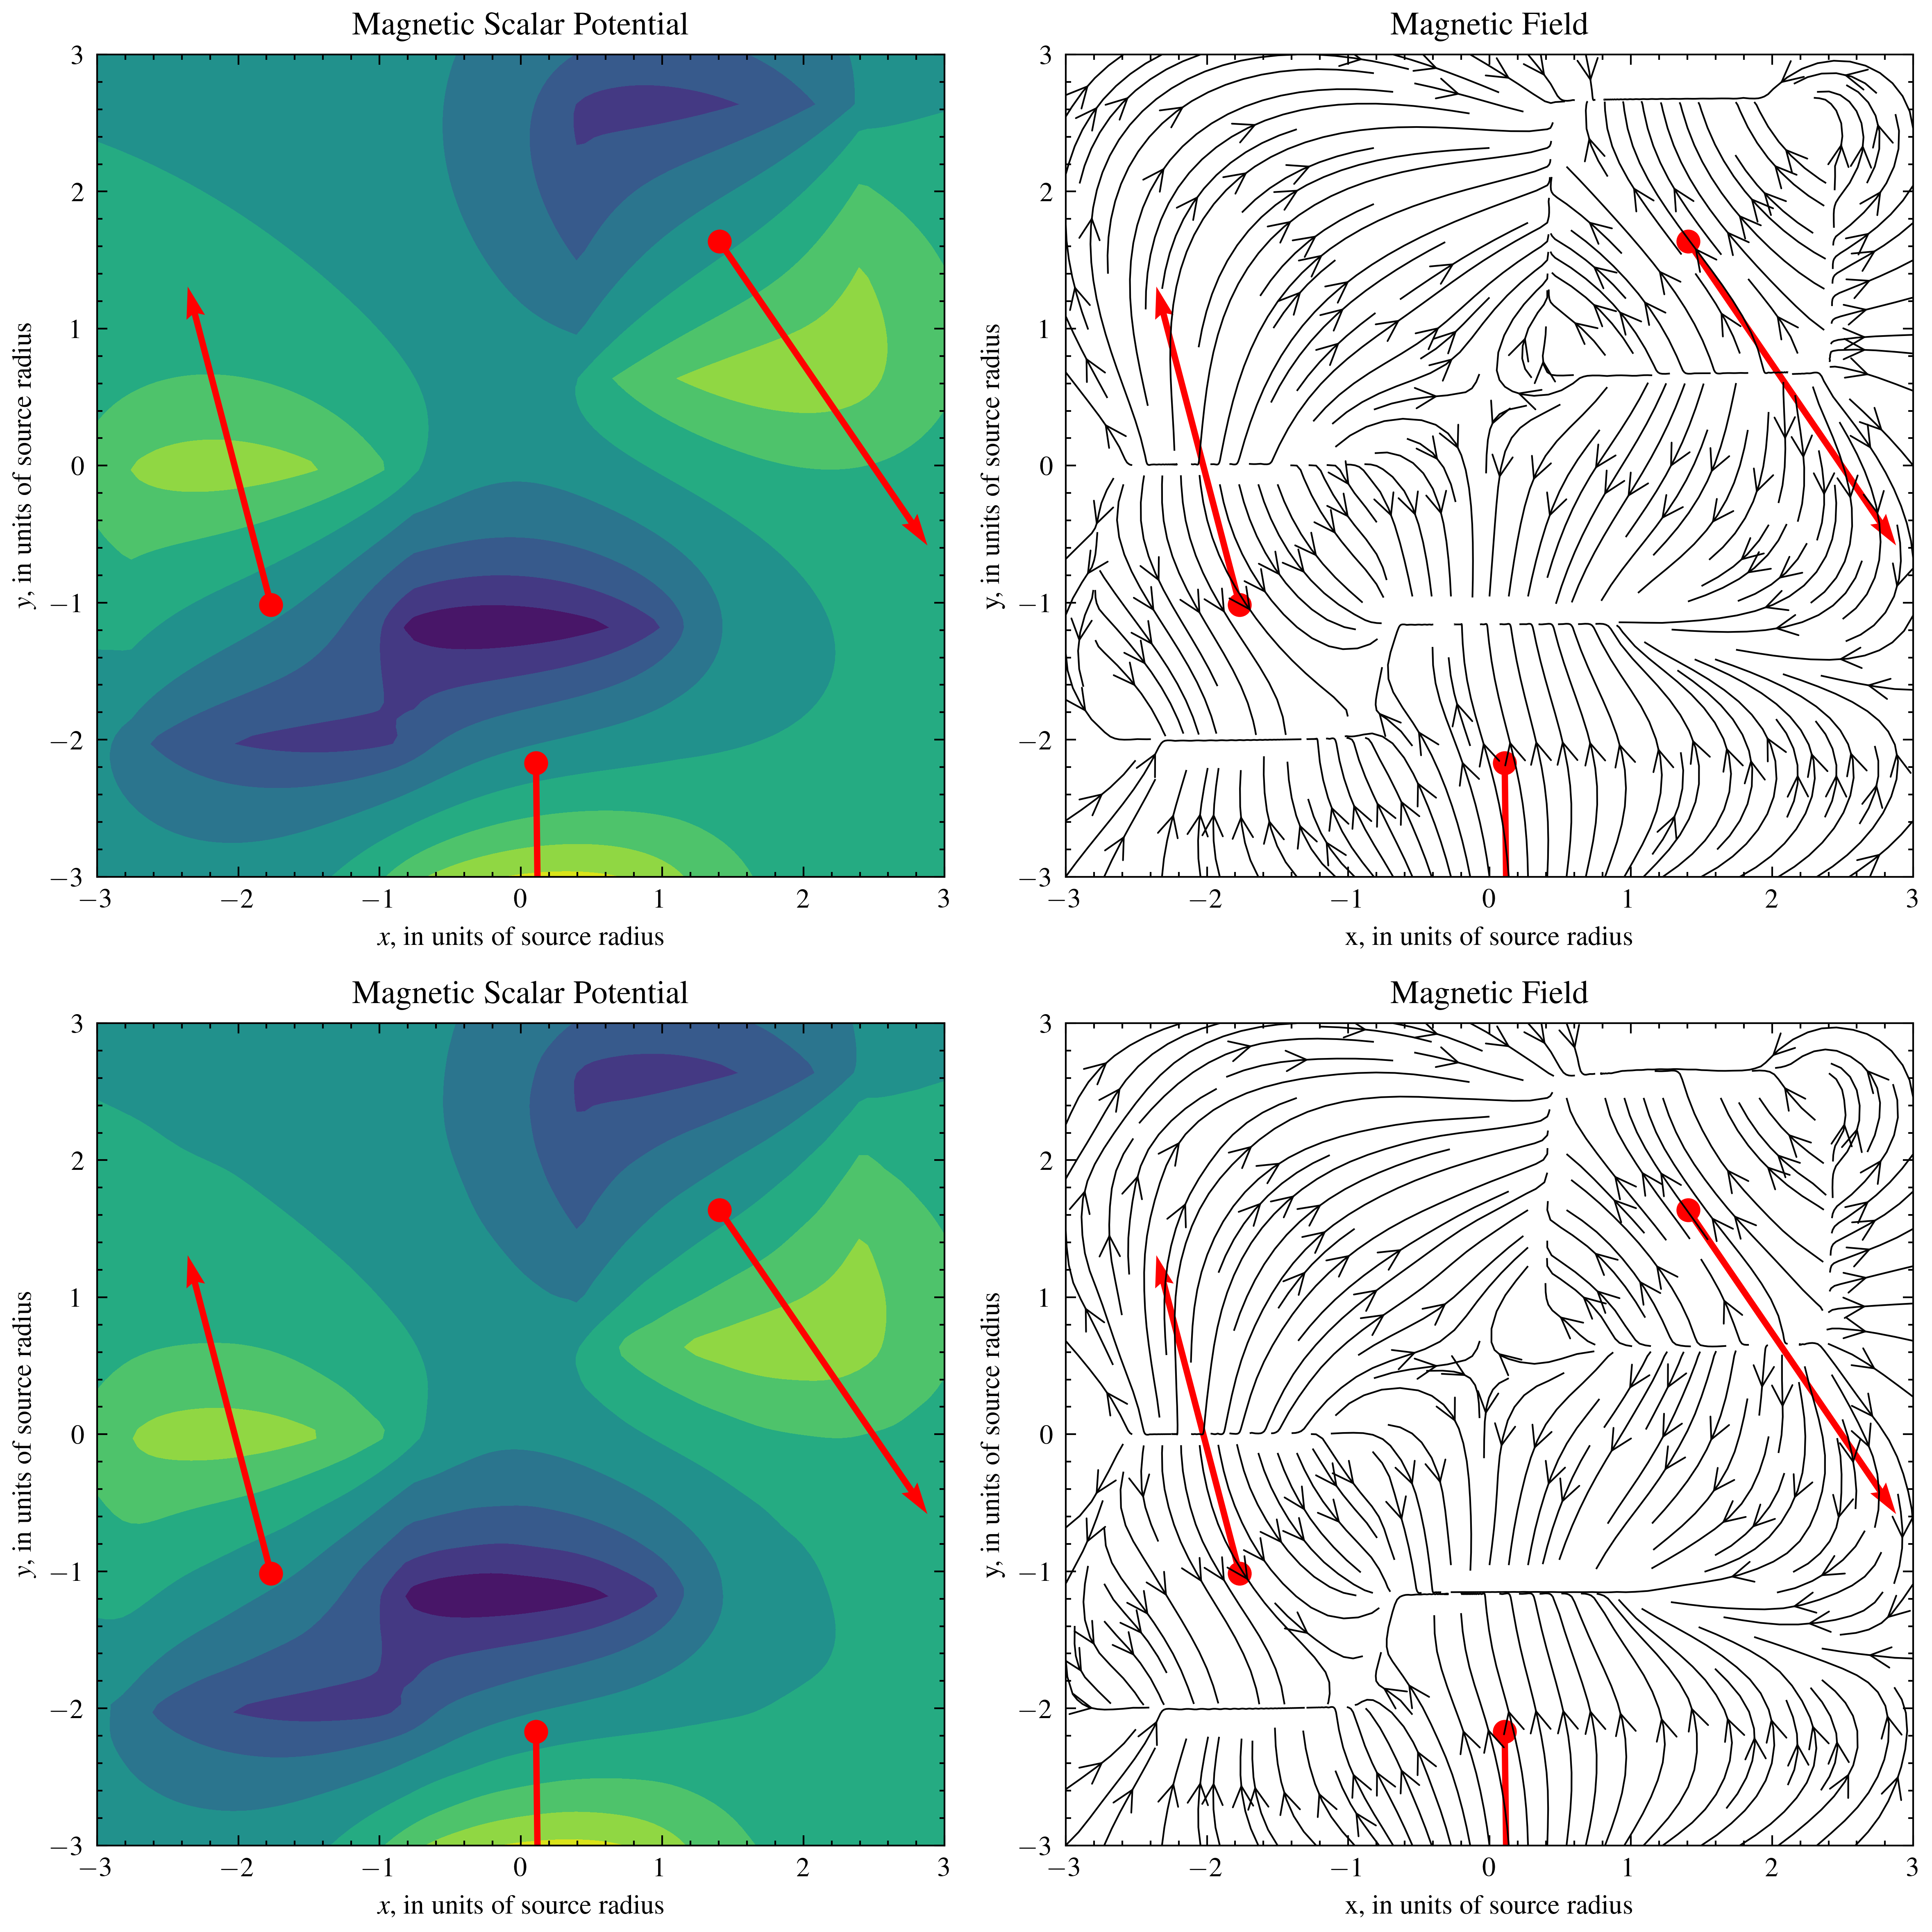

In [7]:
plots(train, model=model)